In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# # InteractiveShell.ast_node_interactivity = "last_expr"

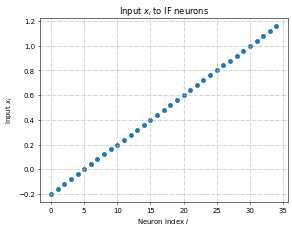

In [3]:
import torch
from spikingjelly.activation_based import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 50
if_node = neuron.IFNode(v_reset=None)
T = 128
x = torch.arange(-0.2, 1.2, 0.04)
plt.scatter(torch.arange(x.shape[0]), x)
plt.title('Input $x_{i}$ to IF neurons')
plt.xlabel('Neuron index $i$')
plt.ylabel('Input $x_{i}$')
plt.grid(linestyle='-.')
plt.show()

In [10]:
if_node(x).unsqueeze(0).shape
x.shape

torch.Size([1, 35])

torch.Size([35])

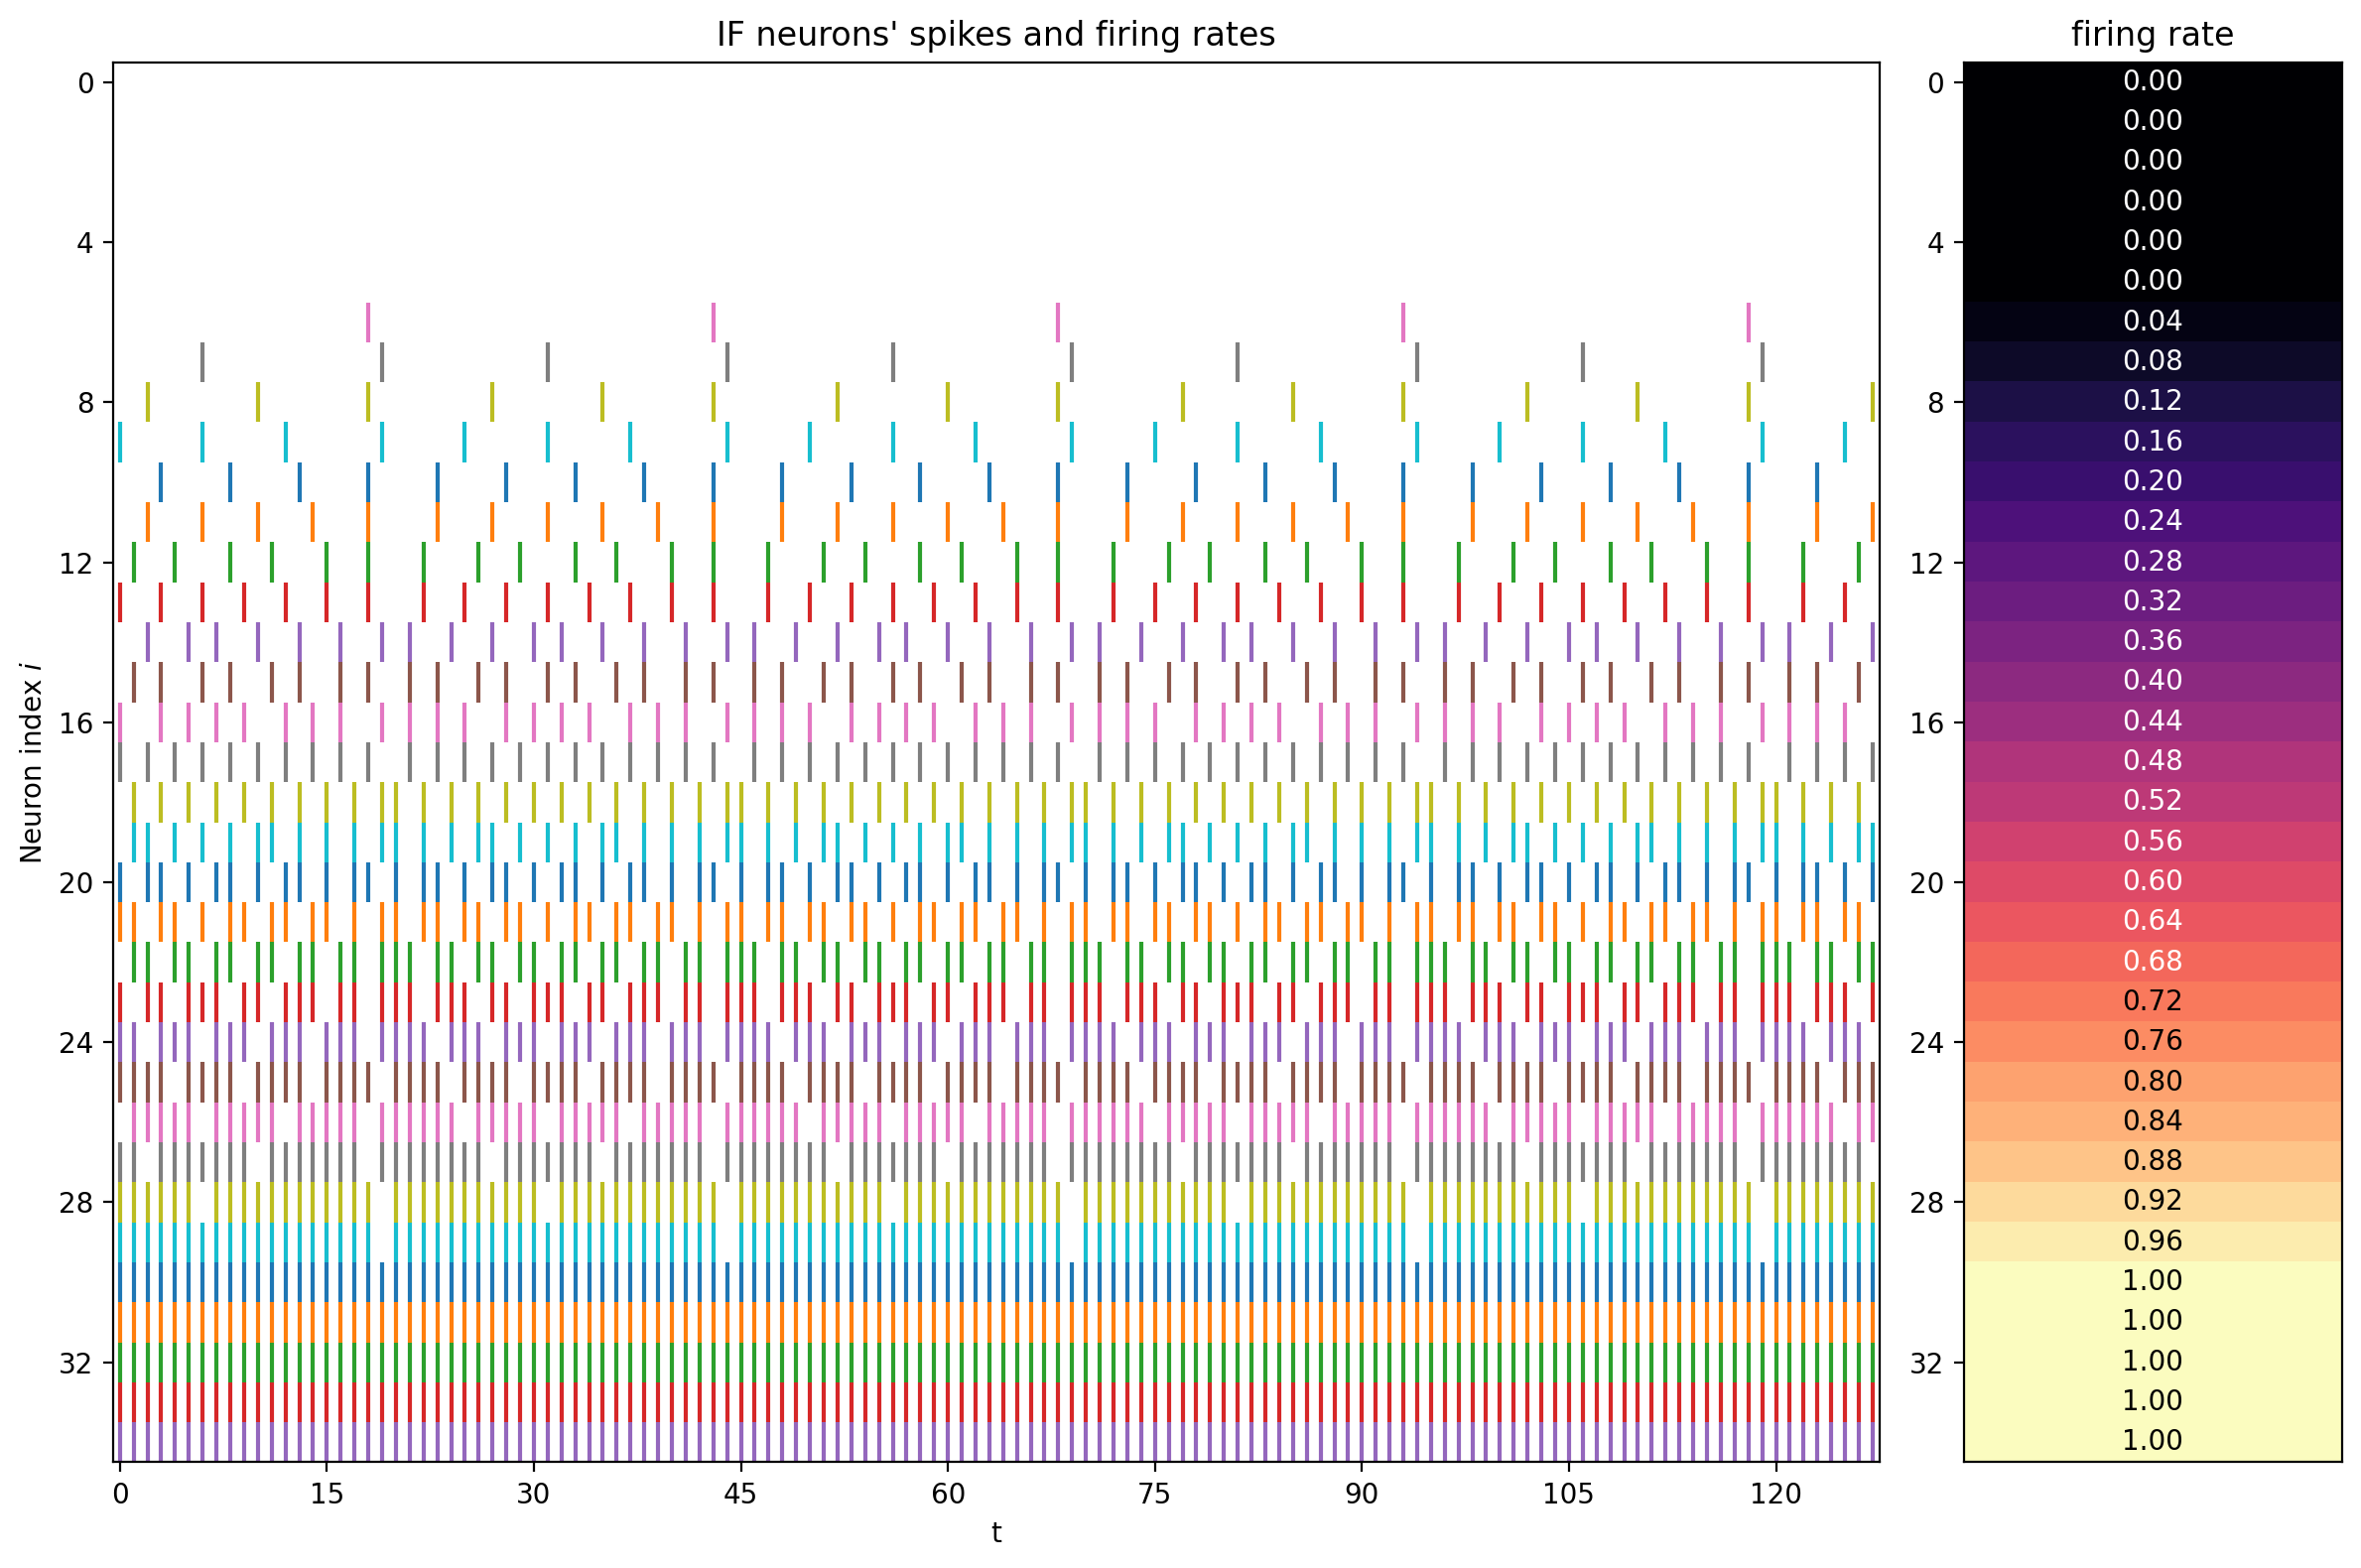

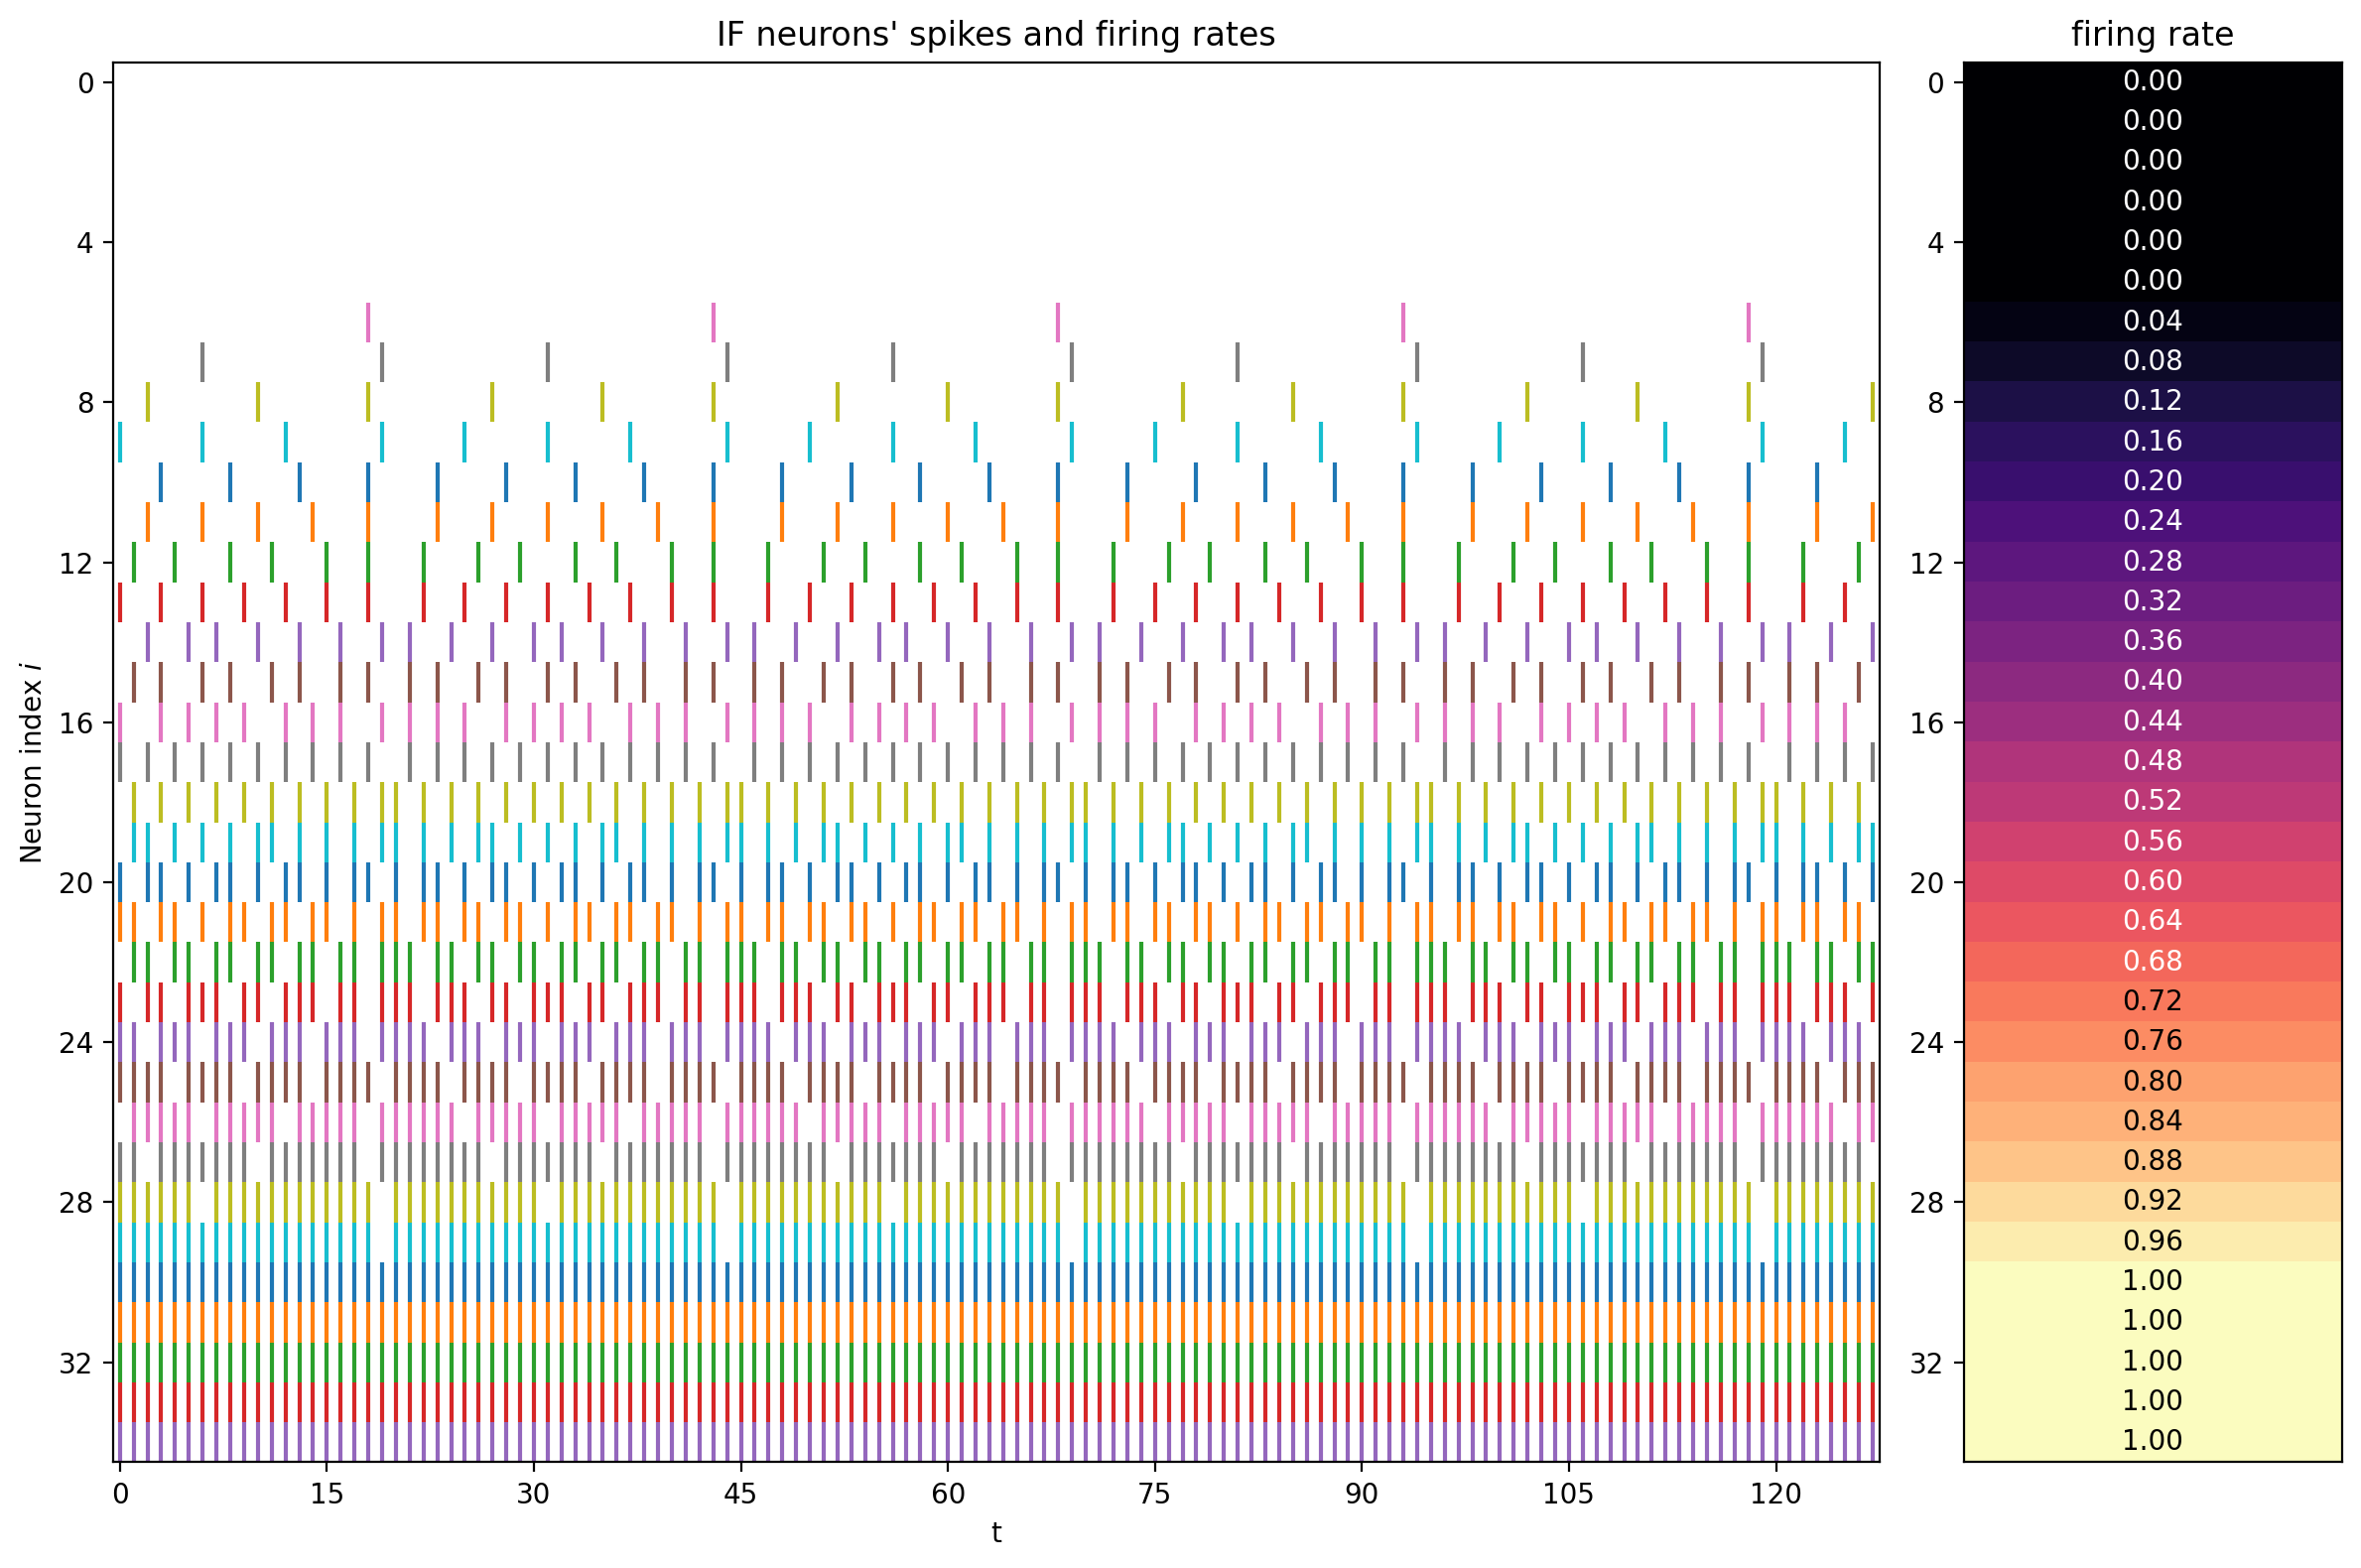

In [11]:
s_list = []
for t in range(T):
    s_list.append(if_node(x).unsqueeze(0))

out_spikes = np.asarray(torch.cat(s_list))
visualizing.plot_1d_spikes(out_spikes, 'IF neurons\' spikes and firing rates', 't', 'Neuron index $i$')
plt.show()

<Axes: >

Text(0.5, 1.0, 'Input $x_{i}$ and firing rate')

Text(0.5, 0, 'Input $x_{i}$')

Text(0, 0.5, 'Firing rate')

<Axes: >

Text(0.5, 1.0, 'Input $x_{i}$ and ReLU($x_{i}$)')

Text(0.5, 0, 'Input $x_{i}$')

Text(0, 0.5, 'ReLU($x_{i}$)')

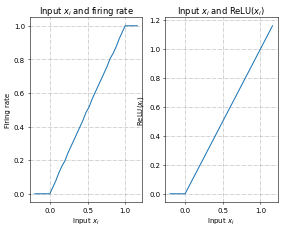

In [18]:
plt.subplot(1, 2, 1)
firing_rate = np.mean(out_spikes, axis=0)
plt.plot(x, firing_rate)
plt.title('Input $x_{i}$ and firing rate')
plt.xlabel('Input $x_{i}$')
plt.ylabel('Firing rate')
plt.grid(linestyle='-.')

plt.subplot(1, 2, 2)
plt.plot(x, x.relu())
plt.title('Input $x_{i}$ and ReLU($x_{i}$)')
plt.xlabel('Input $x_{i}$')
plt.ylabel('ReLU($x_{i}$)')
plt.grid(linestyle='-.')
plt.show()

### ANN to SNN 实例

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# # InteractiveShell.ast_node_interactivity = "last_expr"

import torch
from spikingjelly.activation_based import surrogate
from spikingjelly.activation_based import encoding
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from spikingjelly.activation_based import monitor, neuron, functional, layer
import sys
import numpy as np
from torch.cuda import amp
import time
import matplotlib.pyplot as plt
import torch.nn as nn
import datetime
# from sew_resnet import *

In [31]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            # 该函数可将 b,c,h,w 变为 b,c*h*w
            nn.Flatten(),
            nn.Linear(32, 10),
            nn.ReLU()
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [36]:
# 数据集获取
def get_mnist(data_path, batch_size):
    # Define a transform
    transform = transforms.Compose([
                transforms.Resize((28, 28)),
    #             transforms.Grayscale(),
                transforms.ToTensor(),
#                 transforms.Normalize((0,), (1,))
                ])

    mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
    mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return train_loader,test_loader

# 测试集评估函数
def evaluates3(name, model, data_loader, num_class = 10):
    acc = 0
    losss = 0
    data_num = 0
    loss_function = nn.CrossEntropyLoss()
    _ = model.eval()

    datas = tqdm(iter(data_loader),file=sys.stdout)
    with torch.no_grad():
        for data, targets in datas:
            data = data.to(device)
            targets = targets.to(device)
            
            out_fr = model(data) # 将每次输出的脉冲进行相加

            loss = loss_function(out_fr, targets)
            data_num += targets.numel()
            losss += loss.item() * targets.numel()
            # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
            acc += (out_fr.argmax(1) == targets).float().sum().item()
            
            functional.reset_net(model)

#             del data, targets,loss
#             torch.cuda.empty_cache()
    
    print(f"{name} All Acc: {acc/data_num * 100:.2f}%")
    print(f"{name} All Loss: {losss/data_num:.4f}")
#     print("\n")
    return acc/data_num, losss/data_num

In [37]:
T = 50
batch_size = 100
lr = 1e-3
num_epochs = 10
num_class = 10
data_path='../data/mnist'

# 配置数据集
train_loader,test_loader = get_mnist(data_path, batch_size)
# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = _sew_resnet(block = BasicBlock, layers = [1,1,1,1], input_channels = 1, num_classes = num_class, connect_f = 'AND',T = T).to(device)
net = ANN().to(device)  

# 定义损失函数
loss_function = nn.CrossEntropyLoss()
# 使用Adam优化器
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs = []
train_losss = []
test_accs = []
test_losss = []
best_acc = 0

In [38]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img) 
                loss = loss_function(out_fr, label)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img) 
            loss = loss_function(out_fr, label)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs.append(train_acc/train_samples)
    train_losss.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_class)
    test_accs.append(test_acc)
    test_losss.append(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'save_model/ANN_lr0.001_mnist.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    
# torch.save(model.state_dict(), 'sample_model.pt')
# loaded_model = nn.Sequential(nn.Linear(128, 16), nn.ReLU(), nn.Linear(16, 1))
# loaded_model.load_state_dict(torch.load('sample_model.pt'))
# print(loaded_model)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.87it/s]
epoch = 0
train_single_time = 20.0858
loss = 0.3880
acc = 93.48%
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.98it/s]
test All Acc: 97.84%
test All Loss: 0.1001
save model param
escape time = 2024-07-26 21:59:13



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.40it/s]
epoch = 1
train_single_time = 19.7428
loss = 0.0771
acc = 98.09%
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.14it/s]
test All Acc: 98.57%
test All Loss: 0.0562
save model param
escape time = 2024-07-26 21:59:09



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.33it/s]
epoch = 2
train_single_time = 19.7830
loss = 0.0545
acc = 98.50%
100%|██████

In [39]:
net.load_state_dict(torch.load('save_model/ANN_lr0.001_mnist.pt'))
test_acc,test_loss = evaluates3("test", net, test_loader,num_class)
print('ANN Validating Accuracy: %.4f' % (test_acc))

<All keys matched successfully>

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.03it/s]
test All Acc: 99.14%
test All Loss: 0.0293
ANN Validating Accuracy: 0.9914


##### 使用convert对网络进行转换

In [41]:
from spikingjelly.activation_based import ann2snn
model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
snn_model = model_converter(net)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:14<00:00, 42.08it/s]


In [42]:
snn_model

ANN(
  (network): Module(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32, out_features=10, bias=True)
  )
  (snn tailor): Module(
    (0): Module(
      (0): VoltageScaler(0.144879)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(6.902327)
    )
    (1): Module(
      (0): VoltageScaler(0.221113)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
   

In [43]:
ANN()

ANN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32, out_features=10, bias=True)
    (14): ReLU()
  )
)

In [46]:
snn_model.graph.print_tabular()

opcode       name            target          args               kwargs
-----------  --------------  --------------  -----------------  --------
placeholder  x               x               ()                 {}
call_module  network_0       network.0       (x,)               {}
call_module  snn_tailor_0_1  snn tailor.0.0  (network_0,)       {}
call_module  snn_tailor_0_2  snn tailor.0.1  (snn_tailor_0_1,)  {}
call_module  snn_tailor_0_3  snn tailor.0.2  (snn_tailor_0_2,)  {}
call_module  network_3       network.3       (snn_tailor_0_3,)  {}
call_module  network_4       network.4       (network_3,)       {}
call_module  snn_tailor_1_1  snn tailor.1.0  (network_4,)       {}
call_module  snn_tailor_1_2  snn tailor.1.1  (snn_tailor_1_1,)  {}
call_module  snn_tailor_1_3  snn tailor.1.2  (snn_tailor_1_2,)  {}
call_module  network_7       network.7       (snn_tailor_1_3,)  {}
call_module  network_8       network.8       (network_7,)       {}
call_module  snn_tailor_2_1  snn tailor.2.0  (networ

In [47]:
type(snn_model)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

In [48]:
def val(net, device, data_loader, T=None):
    net.eval().to(device)
    correct = 0.0
    total = 0.0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch, (img, label) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            if T is None:
                out = net(img)
                correct += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            else:
                for m in net.modules():
                    if hasattr(m, 'reset'):  # 检查m模块是否有 reset函数
                        m.reset()
                for t in range(T):
                    if t == 0:
                        out = net(img)
                    else:
                        out += net(img)
                    corrects[t] += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            total += out.shape[0]
    return correct / total if T is None else corrects / total

In [51]:
model = net
train_data_loader = train_loader
test_data_loader = test_loader

print('---------------------------------------------')
print('Converting using MaxNorm')
model_converter = ann2snn.Converter(mode='max', dataloader=train_data_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_max_accs = val(snn_model, device, test_data_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_max_accs[-1]))

print('---------------------------------------------')
print('Converting using RobustNorm')
model_converter = ann2snn.Converter(mode='99.9%', dataloader=train_data_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_robust_accs = val(snn_model, device, test_data_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_robust_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/2 max(activation) as scales...')
model_converter = ann2snn.Converter(mode=1.0 / 2, dataloader=train_data_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_two_accs = val(snn_model, device, test_data_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_two_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/3 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 3, dataloader=train_data_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_three_accs = val(snn_model, device, test_data_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_three_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/4 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 4, dataloader=train_data_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_four_accs = val(snn_model, device, test_data_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_four_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/5 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 5, dataloader=train_data_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_five_accs = val(snn_model, device, test_data_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_five_accs[-1]))

---------------------------------------------
Converting using MaxNorm


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 42.99it/s]


Simulating...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


SNN accuracy (simulation 50 time-steps): 0.9874
---------------------------------------------
Converting using RobustNorm


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:35<00:00, 16.91it/s]


Simulating...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]


SNN accuracy (simulation 50 time-steps): 0.9902
---------------------------------------------
Converting using 1/2 max(activation) as scales...


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 44.91it/s]


Simulating...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.60it/s]


SNN accuracy (simulation 50 time-steps): 0.9899
---------------------------------------------
Converting using 1/3 max(activation) as scales


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 44.44it/s]


Simulating...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


SNN accuracy (simulation 50 time-steps): 0.9863
---------------------------------------------
Converting using 1/4 max(activation) as scales


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 43.85it/s]


Simulating...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.34it/s]


SNN accuracy (simulation 50 time-steps): 0.9716
---------------------------------------------
Converting using 1/5 max(activation) as scales


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 44.91it/s]


Simulating...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.62it/s]

SNN accuracy (simulation 50 time-steps): 0.9437


##### ANN to SNN 的 Convert.py函数

In [ ]:
from typing import Type, Dict, Any, Tuple, Iterable
from spikingjelly.activation_based import neuron
from spikingjelly.activation_based.ann2snn.modules import *
from torch import fx
from torch.nn.utils.fusion import fuse_conv_bn_eval
from tqdm import tqdm


class Converter(nn.Module):

    def __init__(self, dataloader, device=None, mode='Max', momentum=0.1, fuse_flag=True):
        """
        * :ref:`API in English <Converter.__init__-en>`

        .. _Converter.__init__-cn:

        :param dataloader: 数据加载器
        :type dataloader: Dataloader
        :param device: Device
        :type device: str
        :param mode: 转换模式。目前支持三种模式: 最大电流转换模式mode='max'，99.9%电流转换模式mode='99.9%'，以及缩放转换模式mode=x（0<x<=1）
        :type mode: str, float
        :param momentum: 动量值，用于modules.VoltageHook
        :type momentum: float
        :param fuse_flag: 标志位，设置为True，则进行conv与bn的融合，反之不进行。
        :type fuse_flag: bool

        ``Converter`` 用于将带有ReLU的ANN转换为SNN。

        ANN2SNN教程见此处 `ANN转换SNN <https://spikingjelly.readthedocs.io/zh_CN/latest/activation_based/ann2snn.html>`_ 。

        目前支持三种转换模式，由参数mode进行设置。

        转换后ReLU模块被删除，SNN需要的新模块（包括VoltageScaler、IFNode等)被创建并存放在snn tailor父模块中。

        由于返回值的类型为fx.GraphModule，建议使用print(fx.GraphModule.graph)查看计算图及前向传播关系。更多API参见 `GraphModule <https://pytorch.org/docs/stable/fx.html?highlight=graphmodule#torch.fx.GraphModule>`_ 。

        .. warning::

            必须确保ANN中的 ``ReLU`` 为module而非function。

            您最好在ANN模型中使用平均池化而不是最大池化。否则，可能会损害转换后的SNN模型的性能。

        * :ref:`中文API <Converter.__init__-cn>`

        .. _Converter.__init__-en:

        :param dataloader: Dataloader for converting
        :type dataloader: Dataloader
        :param device: Device
        :type device: str
        :param mode: Conversion mode. Now support three mode, MaxNorm(mode='max'), RobustNorm(mode='99.9%'), and scaling mode(mode=x, where 0<x<=1)
        :type mode: str, float
        :param momentum: Momentum value used by modules.VoltageHook
        :type momentum: float
        :param fuse_flag: Bool specifying if fusion of the conv and the bn happens, by default it happens.
        :type fuse_flag: bool

        ``Converter`` is used to convert ANN with to SNN.

        ANN2SNN tutorial is here `ANN2SNN <https://spikingjelly.readthedocs.io/zh_CN/latest/activation_based_en/ann2snn.html>`_ .

        Three common methods are implemented here, which can be selected by the value of parameter mode.

        After converting, ReLU modules will be removed. And new modules needed by SNN, such as VoltageScaler and IFNode, will be created and stored in the parent module 'snn tailor'.

        Due to the type of the return model is fx.GraphModule, you can use 'print(fx.GraphModule.graph)' to view how modules links and the how the forward method works. More APIs are here `GraphModule <https://pytorch.org/docs/stable/fx.html?highlight=graphmodule#torch.fx.GraphModule>`_ .

        .. warning::

            Make sure that ``ReLU`` is module rather than function.

            You'd better use ``avgpool`` rather than ``maxpool`` in your ann model. If not, the performance of the converted snn model may be ruined.
        """
        super().__init__()
        self.mode = mode
        self.fuse_flag = fuse_flag
        self.dataloader = dataloader
        self._check_mode()
        self.device = device
        self.momentum = momentum

    def forward(self, ann: nn.Module):
        """
        * :ref:`API in English <Converter.forward-en>`

        .. _Converter.forward-cn:
        :param ann: 待转换的ann
        :type ann: torch.nn.Module
        :return: 转换得到的snn
        :rtype: torch.fx.GraphModule

        * :ref:`API in Chinese <Converter.forward-cn>`

        .. _Converter.forward-en:
        :param ann: ann to be converted
        :type ann: torch.nn.Module
        :return: snn
        :rtype: torch.fx.GraphModule

        """
        if self.device is None:
            self.device = next(ann.parameters()).device
        ann = fx.symbolic_trace(ann).to(self.device)
        ann.eval()
        ann_fused = self.fuse(ann, fuse_flag=self.fuse_flag).to(self.device)
        ann_with_hook = self.set_voltagehook(ann_fused, momentum=self.momentum, mode=self.mode).to(self.device)
        for _, (imgs, _) in enumerate(tqdm(self.dataloader)):
            ann_with_hook(imgs.to(self.device))
        snn = self.replace_by_ifnode(ann_with_hook).to(self.device)
        return snn  # return type: GraphModule

    def _check_mode(self):
        err_msg = 'You have used a non-defined VoltageScale Method.'
        if isinstance(self.mode, str):
            if self.mode[-1] == '%':
                try:
                    float(self.mode[:-1])
                except ValueError:
                    raise NotImplementedError(err_msg)
            elif self.mode.lower() in ['max']:
                pass
            else:
                raise NotImplementedError(err_msg)
        elif isinstance(self.mode, float):
            try:
                assert (self.mode <= 1 and self.mode > 0)
            except AssertionError:
                raise NotImplementedError(err_msg)
        else:
            raise NotImplementedError(err_msg)

    @staticmethod
    def fuse(fx_model: torch.fx.GraphModule, fuse_flag: bool = True) -> torch.fx.GraphModule:
        """
        * :ref:`API in English <Converter.fuse-en>`

        .. _Converter.fuse-cn:

        :param fx_model: 原模型
        :type fx_model: torch.fx.GraphModule
        :param fuse_flag: 标志位，设置为True，则进行conv与bn的融合，反之不进行。
        :type fuse_flag: bool
        :return: conv层和bn层融合后的模型.
        :rtype: torch.fx.GraphModule

        ``fuse`` 用于conv与bn的融合。

        * :ref:`中文API <Converter.fuse-cn>`

        .. _Converter.fuse-en:

        :param fx_model: Original fx_model
        :type fx_model: torch.fx.GraphModule
        :param fuse_flag: Bool specifying if fusion of the conv and the bn happens, by default it happens.
        :type fuse_flag: bool
        :return: fx_model whose conv layer and bn layer have been fused.
        :rtype: torch.fx.GraphModule

        ``fuse`` is used to fuse conv layer and bn layer.

        """

        def matches_module_pattern(pattern: Iterable[Type], node: fx.Node, modules: Dict[str, Any]) -> bool:
            if len(node.args) == 0:
                return False
            nodes: Tuple[Any, fx.Node] = (node.args[0], node)
            for expected_type, current_node in zip(pattern, nodes):
                if not isinstance(current_node, fx.Node):
                    return False
                if current_node.op != 'call_module':
                    return False
                if not isinstance(current_node.target, str):
                    return False
                if current_node.target not in modules:
                    return False
                if type(modules[current_node.target]) is not expected_type:
                    return False
            return True

        def replace_node_module(node: fx.Node, modules: Dict[str, Any],
                                new_module: torch.nn.Module):
            def parent_name(target: str) -> Tuple[str, str]:
                """
                Splits a qualname into parent path and last atom.
                For example, `foo.bar.baz` -> (`foo.bar`, `baz`)
                """
                *parent, name = target.rsplit('.', 1)
                return parent[0] if parent else '', name

            assert (isinstance(node.target, str))
            parent_name, name = parent_name(node.target)
            modules[node.target] = new_module
            setattr(modules[parent_name], name, new_module)

        if not fuse_flag:
            return fx_model
        patterns = [(nn.Conv1d, nn.BatchNorm1d),
                    (nn.Conv2d, nn.BatchNorm2d),
                    (nn.Conv3d, nn.BatchNorm3d)]

        modules = dict(fx_model.named_modules())

        for pattern in patterns:
            for node in fx_model.graph.nodes:
                if matches_module_pattern(pattern, node,
                                          modules):
                    if len(node.args[0].users) > 1:  # Output of conv is used by other nodes
                        continue
                    conv = modules[node.args[0].target]
                    bn = modules[node.target]
                    fused_conv = fuse_conv_bn_eval(conv, bn)
                    replace_node_module(node.args[0], modules,
                                        fused_conv)
                    node.replace_all_uses_with(node.args[0])
                    fx_model.graph.erase_node(node)
        fx_model.graph.lint()
        fx_model.delete_all_unused_submodules()  # remove unused bn modules
        fx_model.recompile()
        return fx_model

    @staticmethod
    def set_voltagehook(fx_model: torch.fx.GraphModule, mode='Max', momentum=0.1) -> torch.fx.GraphModule:
        """
        * :ref:`API in English <Converter.set_voltagehook-en>`

        .. _Converter.set_voltagehook-cn:

        :param fx_model: 原模型
        :type fx_model: torch.fx.GraphModule
        :param mode: 转换模式。目前支持三种模式，最大电流转换模式，99.9%电流转换模式，以及缩放转换模式
        :type mode: str, float
        :param momentum: 动量值，用于VoltageHook
        :type momentum: float
        :return: 带有VoltageHook的模型.
        :rtype: torch.fx.GraphModule

        ``set_voltagehook`` 用于给模型添加VoltageHook模块。这里实现了常见的三种模式，同上。

        * :ref:`中文API <Converter.set_voltagehook-cn>`

        .. _Converter.set_voltagehook-en:

        :param fx_model: Original fx_model
        :type fx_model: torch.fx.GraphModule
        :param mode: Conversion mode. Now support three mode, MaxNorm, RobustNorm(99.9%), and scaling mode
        :type mode: str, float
        :param momentum: momentum value used by VoltageHook
        :type momentum: float
        :return: fx_model with VoltageHook.
        :rtype: torch.fx.GraphModule

        ``set_voltagehook`` is used to add VoltageHook to fx_model. Three common methods are implemented here, the same as Converter.mode.

        """

        hook_cnt = -1
        for node in fx_model.graph.nodes:
            if node.op != 'call_module':
                continue
            if type(fx_model.get_submodule(node.target)) is nn.ReLU:
                hook_cnt += 1
                target = 'snn tailor.' + str(hook_cnt) + '.0'  # voltage_hook
                m = VoltageHook(momentum=momentum, mode=mode)
                new_node = Converter._add_module_and_node(fx_model, target, node, m
                                                          , (node,))
        fx_model.graph.lint()
        fx_model.recompile()
        return fx_model

    @staticmethod
    def replace_by_ifnode(fx_model: torch.fx.GraphModule) -> torch.fx.GraphModule:
        """
        * :ref:`API in English <Converter.replace_by_ifnode-en>`

        .. _Converter.replace_by_ifnode-cn:

        :param fx_model: 原模型
        :type fx_model: torch.fx.GraphModule
        :return: 将ReLU替换为IF脉冲神经元后的模型.
        :rtype: torch.fx.GraphModule

        ``replace_by_ifnode`` 用于将模型的ReLU替换为IF脉冲神经元。

        * :ref:`中文API <Converter.replace_by_ifnode-cn>`

        .. _Converter.replace_by_ifnode-en:

        :param fx_model: Original fx_model
        :type fx_model: torch.fx.GraphModule
        :return: fx_model whose ReLU has been replaced by IF neuron.
        :rtype: torch.fx.GraphModule

        ``replace_by_ifnode`` is used to replace ReLU with IF neuron.

        """

        hook_cnt = -1
        for node in fx_model.graph.nodes:
            if node.op != 'call_module':
                continue
            if type(fx_model.get_submodule(node.target)) is VoltageHook:
                if type(fx_model.get_submodule(node.args[0].target)) is nn.ReLU:
                    hook_cnt += 1
                    hook_node = node
                    relu_node = node.args[0]
                    if len(relu_node.args) != 1:
                        raise NotImplementedError('The number of relu_node.args should be 1.')
                    s = fx_model.get_submodule(node.target).scale.item()
                    target0 = 'snn tailor.' + str(hook_cnt) + '.0'  # voltage_scaler
                    target1 = 'snn tailor.' + str(hook_cnt) + '.1'  # IF_node
                    target2 = 'snn tailor.' + str(hook_cnt) + '.2'  # voltage_scaler
                    m0 = VoltageScaler(1.0 / s)
                    m1 = neuron.IFNode(v_threshold=1., v_reset=None)
                    m2 = VoltageScaler(s)
                    node0 = Converter._add_module_and_node(fx_model, target0, hook_node, m0,
                                                           relu_node.args)
                    node1 = Converter._add_module_and_node(fx_model, target1, node0, m1
                                                           , (node0,))
                    node2 = Converter._add_module_and_node(fx_model, target2, node1, m2, args=(node1,))

                    relu_node.replace_all_uses_with(node2)
                    node2.args = (node1,)
                    fx_model.graph.erase_node(hook_node)
                    fx_model.graph.erase_node(relu_node)
                    fx_model.delete_all_unused_submodules()
        fx_model.graph.lint()
        fx_model.recompile()
        return fx_model

    @staticmethod
    def _add_module_and_node(fx_model: fx.GraphModule, target: str, after: fx.Node, m: nn.Module,
                             args: Tuple) -> fx.Node:
        fx_model.add_submodule(target=target, m=m)
        with fx_model.graph.inserting_after(n=after):
            new_node = fx_model.graph.call_module(module_name=target, args=args)
        return new_node

##### 模型算子替换

In [1]:
import torch 
from torch import nn
from torch import fx
from torch.fx import symbolic_trace


class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.param=nn.Parameter(torch.Tensor([1,2,3,4]))
        
    def forward(self,x):
        return (x+self.param).clamp(min=0.0,max=1.0)  # 将输出限制在0和1之间
    

    
model=MyModel()

symbolic_traced=symbolic_trace(model)
print(symbolic_traced.graph)
print(symbolic_traced.code)
symbolic_traced.graph.print_tabular()

graph():
    %x : [num_users=1] = placeholder[target=x]
    %param : [num_users=1] = get_attr[target=param]
    %add : [num_users=1] = call_function[target=operator.add](args = (%x, %param), kwargs = {})
    %clamp : [num_users=1] = call_method[target=clamp](args = (%add,), kwargs = {min: 0.0, max: 1.0})
    return clamp



def forward(self, x):
    param = self.param
    add = x + param;  x = param = None
    clamp = add.clamp(min = 0.0, max = 1.0);  add = None
    return clamp
    
opcode         name    target                   args        kwargs
-------------  ------  -----------------------  ----------  ------------------------
placeholder    x       x                        ()          {}
get_attr       param   param                    ()          {}
call_function  add     <built-in function add>  (x, param)  {}
call_method    clamp   clamp                    (add,)      {'min': 0.0, 'max': 1.0}
output         output  output                   (clamp,)    {}


In [3]:
x = torch.Tensor([1,2,3,4])
x
model(x)

tensor([1., 1., 1., 1.], grad_fn=<ClampBackward1>)

In [4]:
# 将clamp转为sigmoid
def transform(m):
    gm=fx.Tracer().trace(m)
    for node in gm.nodes:
        if node.op=='call_method':
            if node.target=="clamp":
                print(node.target)
                node.target=torch.sigmoid
    gm.lint()
    return fx.GraphModule(m,gm)

trans_model=transform(model)
print(trans_model.graph)
print(trans_model.code)
trans_model.graph.print_tabular()


clamp


AssertionError: 

In [5]:
# 将clamp转为sigmoid
def transform(m):
    gm=fx.Tracer().trace(m)
    for node in gm.nodes:
        if node.op=='call_method':
            if node.name=="clamp":
                print(node.target)
                node.target="sigmoid"
                node.name="sigmoid"
                node.kwargs={}
                
    gm.lint()
    return fx.GraphModule(m,gm)

trans_model=transform(model)
print(trans_model.graph)
print(trans_model.code)
trans_model.graph.print_tabular()

clamp
graph():
    %x : [num_users=1] = placeholder[target=x]
    %param : [num_users=1] = get_attr[target=param]
    %add : [num_users=1] = call_function[target=operator.add](args = (%x, %param), kwargs = {})
    %sigmoid : [num_users=1] = call_method[target=sigmoid](args = (%add,), kwargs = {})
    return sigmoid



def forward(self, x):
    param = self.param
    add = x + param;  x = param = None
    sigmoid = add.sigmoid();  add = None
    return sigmoid
    
opcode         name     target                   args        kwargs
-------------  -------  -----------------------  ----------  --------
placeholder    x        x                        ()          {}
get_attr       param    param                    ()          {}
call_function  add      <built-in function add>  (x, param)  {}
call_method    sigmoid  sigmoid                  (add,)      {}
output         output   output                   (sigmoid,)  {}


In [8]:
class MyModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.param=nn.Parameter(torch.Tensor([1,2,3,4]))
        #self.linear=torch.nn.Linear(4,5)
        
    def forward(self,x):
        return (x+self.param).sigmoid()
    
test=MyModel1()


inputs = torch.randn(1,4)
torch.testing.assert_close(test(inputs),trans_model(inputs))

In [9]:
test(inputs),trans_model(inputs)

(tensor([[0.6096, 0.9650, 0.9423, 0.9191]], grad_fn=<SigmoidBackward0>),
 tensor([[0.6096, 0.9650, 0.9423, 0.9191]], grad_fn=<SigmoidBackward0>))

##### 2.算子融合